<a href="https://colab.research.google.com/github/Shubhammawa/PredictivEye-Internship/blob/master/Retail_Rocket_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing necessary libraries

In [0]:
import numpy as np
import pandas as pd
import time
import datetime

%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!unzip "/content/drive/My Drive/ecommerce-dataset.zip"

Archive:  /content/drive/My Drive/ecommerce-dataset.zip
replace category_tree.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
events_df = pd.read_csv('events.csv')
category_tree_df = pd.read_csv('category_tree.csv')
item_properties_1_df = pd.read_csv('item_properties_part1.csv')
item_properties_2_df = pd.read_csv('item_properties_part2.csv')
items_df = pd.concat([item_properties_1_df,item_properties_2_df])

In [4]:
times=[]
for i in events_df['timestamp']:
    times.append(datetime.datetime.fromtimestamp(i//1000.0))
events_df['timestamp'] = times
events_df.head()

,timestamp,visitorid,event,itemid,transactionid
0,2015-06-02 05:02:12,257597,view,355908,NaN
1,2015-06-02 05:50:14,992329,view,248676,NaN
2,2015-06-02 05:13:19,111016,view,318965,NaN
3,2015-06-02 05:12:35,483717,view,253185,NaN
4,2015-06-02 05:02:17,951259,view,367447,NaN


In [0]:
category_tree_df.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [0]:
times=[]
for i in items_df['timestamp']:
    times.append(datetime.datetime.fromtimestamp(i//1000.0))
items_df['timestamp'] = times
items_df.head()

,timestamp,itemid,property,value
0,2015-06-28 03:00:00,460429,categoryid,1338
1,2015-09-06 03:00:00,206783,888,1116713 960601 n277.200
2,2015-08-09 03:00:00,395014,400,n552.000 639502 n720.000 424566
3,2015-05-10 03:00:00,59481,790,n15360.000
4,2015-05-17 03:00:00,156781,917,828513


addtocart      69332
transaction    22457
Name: event, dtype: int64


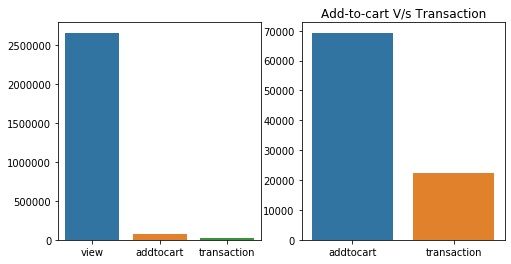

In [0]:
events_count = events_df["event"].value_counts()
fig, axs = plt.subplots(ncols = 2,figsize = (8, 4))
#plt.title('Views/Add to Cart/Transactions')
sns.barplot(events_count.index, events_count.values, ax = axs[0])

events_count=events_df["event"].value_counts()[1:]
#plt.title('Actions Vs Count')
g = sns.barplot(events_count.index, events_count.values, ax = axs[1])
#g.set_yscale('log')
events_count = events_df["event"].value_counts()[1:]
plt.title('Add-to-cart V/s Transaction')
sns.barplot(events_count.index, events_count.values)

print(events_count)

In [0]:
# All unique visitor ids
all_customers = events_df.visitorid.unique()
# Total visits
total_visits = events_df.visitorid.size
print("Total number of visits: ",total_visits)
print("Number of unique customers: ",all_customers.size)

Total number of visits:  2756101
Number of unique customers:  1407580


In [0]:
# All unique items
all_items = items_df.itemid.unique()
print("Total unique items: ",all_items.size)

Total unique items:  417053


In [0]:
def user_history(visitor_id):
    user_history = events_df[events_df.visitorid == visitor_id].sort_values('timestamp')
    return user_history

In [0]:
user_history(102013)

,timestamp,visitorid,event,itemid,transactionid
1281305,2015-09-08 02:57:05,102013,view,332816,NaN


In [0]:
user_history(102019)

,timestamp,visitorid,event,itemid,transactionid
19690,2015-06-01 16:21:54,102019,view,49521,NaN
19501,2015-06-01 16:23:21,102019,addtocart,49521,NaN
14842,2015-06-01 16:23:32,102019,view,150318,NaN
19573,2015-06-01 16:24:31,102019,view,49521,NaN
8701,2015-06-01 16:24:54,102019,view,49521,NaN
19708,2015-06-01 16:25:45,102019,view,150318,NaN
8740,2015-06-01 16:27:22,102019,view,49521,NaN
814,2015-06-01 16:38:56,102019,transaction,150318,13556.0
19724,2015-06-01 16:38:56,102019,transaction,49521,13556.0


In [0]:
# All the customers who made a purchase
customer_purchased = events_df[events_df.transactionid.notnull()].visitorid.unique()
customer_purchased.size

11719

In [0]:
purchased_items = []
    
# Create another list that contains all their purchases 
for customer in customer_purchased:

    #Generate a Pandas series type object containing all the visitor's purchases and put them in the list
    purchased_items.append(list(events_df.loc[(events_df.visitorid == customer) & (events_df.transactionid.notnull())].itemid.values))

In [0]:
# Function that would show items that were bought together
def recommend_bought_together(item_id, purchased_items):
    
    # More efficient implementation required
    recommender_list = []
    for x in purchased_items:
        if item_id in x:
            recommender_list += x
    
    # Merge recommender list and remove the item id
    recommender_list = list(set(recommender_list) - set([item_id]))
    
    return recommender_list

In [0]:
recommend_bought_together(49521,purchased_items)

[150318]

In [0]:
recommend_bought_together(302422, purchased_items)

[105792, 200793, 12836, 80582, 380775, 15335, 400969, 25353, 237753, 317178]

In [0]:
# Grouping itemid by its event type and creating list of each of them
grouped = events_df.groupby('event')['itemid'].apply(list)
grouped

event
addtocart      [5206, 10572, 255275, 356475, 312728, 63312, 1...
transaction    [356475, 15335, 81345, 150318, 310791, 54058, ...
view           [355908, 248676, 318965, 253185, 367447, 22556...
Name: itemid, dtype: object

In [0]:
# Function to find most viewed, added to cart and purchased items
import operator
def product_stats(grouped=grouped, event='view'):
    events = grouped[event]
    # creating dictionary for key value pair 
    count_event ={}
    events = np.array(events[:])
    unique, counts = np.unique(events, return_counts=True)
    # converting unique and counts as a dictionay with key as unique and value as counts
    count_event = dict(zip(unique, counts))
    #sorting the dictionary
    sort_count_event = sorted(count_event.items(), key = operator.itemgetter(1), reverse = True)
    # keeping number of unique views on X-axis
    x = [i[0] for i in sort_count_event[:7]]
    # keeping count number of views on Y-axis
    y = [i[1] for i in sort_count_event[:7]]
    # Print top 5 most-viewed items
    print("Top 5 products in " + str(event) + " category: ",x[:5])
    sns.barplot(x, y, order=x, palette="rocket")

Top 5 products in addtocart category:  [461686, 312728, 409804, 320130, 29196]


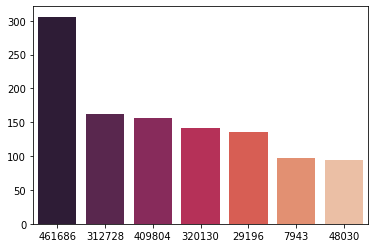

In [0]:
# Call function to see product stats
# events = 'view', 'addtocart', 'transaction'
product_stats(event='addtocart')

In [0]:
events_df.head()

,timestamp,visitorid,event,itemid,transactionid
0,2015-06-02 05:02:12,257597,view,355908,NaN
1,2015-06-02 05:50:14,992329,view,248676,NaN
2,2015-06-02 05:13:19,111016,view,318965,NaN
3,2015-06-02 05:12:35,483717,view,253185,NaN
4,2015-06-02 05:02:17,951259,view,367447,NaN


In [5]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(events_df['event'])

LabelEncoder()

In [6]:
data = events_df
data['event'] = le.transform(data['event'])
data.head()

,timestamp,visitorid,event,itemid,transactionid
0,2015-06-02 05:02:12,257597,2,355908,NaN
1,2015-06-02 05:50:14,992329,2,248676,NaN
2,2015-06-02 05:13:19,111016,2,318965,NaN
3,2015-06-02 05:12:35,483717,2,253185,NaN
4,2015-06-02 05:02:17,951259,2,367447,NaN


In [0]:
data.sort_values(by=['timestamp'], axis=0, inplace=True)

In [0]:
#data.drop(columns='transactionid')

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from torch.autograd import Variable as V

In [0]:
def proc_col(col, train_col=None):
    """Encodes a pandas column with continous ids. 
    """
    if train_col is not None:
        uniq = train_col.unique()
    else:
        uniq = col.unique()
    name2idx = {o: i for i, o in enumerate(uniq)}
    return name2idx, np.array([name2idx.get(x, -1) for x in col]), len(uniq)

In [0]:
def encode_data(df, train=None):
    """ Encodes rating data with continous user and item ids. 
    If train is provided, encodes df with the same encoding as train.
    """
    df = df.copy()
    for col_name in ['visitorid', 'itemid', 'year', 'day', 'month']:
        train_col = None
        if train is not None:
            train_col = train[col_name]
        _, col, _ = proc_col(df[col_name], train_col)
        df[col_name] = col
        df = df[df[col_name] >= 0]
    return df

In [0]:
data['year'] = data.timestamp.dt.year
data['day'] = data.timestamp.dt.day
data['month'] = data.timestamp.dt.month
data = data.drop(['timestamp', 'transactionid'], axis = 1)
data.head()
#data.shape

,visitorid,event,itemid,year,day,month
1462974,693516,0,297662,2015,3,5
1464806,829044,2,60987,2015,3,5
1463000,652699,2,252860,2015,3,5
1465287,1125936,2,33661,2015,3,5
1462955,693516,2,297662,2015,3,5


In [0]:
df_encode = encode_data(data)

print(df_encode.shape)

(2756101, 6)


In [0]:
k = round(len(df_encode) * 0.8)
train = df_encode[:k]
val = df_encode[k:]

In [0]:
train.shape, val.shape

((2204881, 6), (551220, 6))

In [0]:
class CustomDataset(Dataset):
    def __init__(self, df):
        self.u = torch.LongTensor(df.visitorid.values)
        self.v = torch.LongTensor(df.itemid.values)
        self.y = torch.LongTensor(df.event.values)

    def __len__(self):
        self.len = len(self.u)
        return self.len

    def __getitem__(self, index):
        return self.u[index], self.v[index], self.y[index]

In [0]:
num_users = len(df_encode.visitorid.unique())
num_items = len(df_encode.itemid.unique())
emb_size = 50
num_users, num_items

(1407580, 235061)

In [0]:
class MF(nn.Module):
    def __init__(self, num_user, num_item, emb_size):
        super(MF, self).__init__()
        self.user_emb = nn.Embedding(num_user, emb_size)
        self.item_emb = nn.Embedding(num_item, emb_size)
        self.user_emb.weight.data.uniform_(0, 0.05)
        self.item_emb.weight.data.uniform_(0, 0.05)

    def forward(self, u, v):
        u = self.user_emb(u)
        v = self.item_emb(v)
        return F.sigmoid((u * v).sum(1)) * 4 + 1

In [0]:
train_ds = CustomDataset(train[['visitorid', 'event', 'itemid']])
train_dl = DataLoader(train_ds, batch_size=100000, shuffle=True)

In [0]:
model = MF(num_users, num_items, emb_size).cuda()
model

MF(
  (user_emb): Embedding(1407580, 50)
  (item_emb): Embedding(235061, 50)
)

In [0]:
def test_loss(model, val):
    model.eval()
    preds = []
    user = V(torch.LongTensor(val.visitorid.values)).cuda()
    item = V(torch.LongTensor(val.itemid.values)).cuda()
    event = V(torch.LongTensor(val.event.values)).float().cuda()
    y_hat = model(user, item)
    loss = F.mse_loss(y_hat, event)
    #     print("Validation loss %.3f " % loss.data[0])
    #     return y_hat
    return loss.data

In [0]:
def train_loop(model, train_dl, val, epochs, learning_rate, wd=0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimiser = torch.optim.Adam(parameters, learning_rate, weight_decay=wd)
    for i in range(epochs):
        model.train()
        for j, d in enumerate(train_dl):
            mb_loss = []
            user = V(d[0]).cuda()
            item = V(d[1]).cuda()
            event = V(d[2]).float().cuda()
            y_hat = model(user, item)
            loss = F.mse_loss(y_hat, event)
            optimiser.zero_grad()
            loss.backward()
            mb_loss.append(loss.data)
            optimiser.step()
        print(f'Training loss for epoch {i} = {(mb_loss)}')
        print(f'Validation loss for epoch {i} = {test_loss(model, val)}')

In [0]:
train_loop(model, train_dl, val[['visitorid', 'event', 'itemid']], 3, 0.05, wd=0.00001)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Training loss for epoch 0 = [tensor(0.9080, device='cuda:0')]
Validation loss for epoch 0 = 1.1786448955535889
Training loss for epoch 1 = [tensor(0.9472, device='cuda:0')]
Validation loss for epoch 1 = 1.1823498010635376
Training loss for epoch 2 = [tensor(0.9044, device='cuda:0')]
Validation loss for epoch 2 = 1.180809497833252


In [0]:
events_df.head()

,timestamp,visitorid,event,itemid,transactionid,year,day,month
1462974,2015-05-03 03:00:04,693516,0,297662,NaN,2015,3,5
1464806,2015-05-03 03:00:11,829044,2,60987,NaN,2015,3,5
1463000,2015-05-03 03:00:13,652699,2,252860,NaN,2015,3,5
1465287,2015-05-03 03:00:24,1125936,2,33661,NaN,2015,3,5
1462955,2015-05-03 03:00:26,693516,2,297662,NaN,2015,3,5


In [0]:
df = events_df#[]
df = df.reindex(columns=['visitorid', 'itemid', 'event', 'timestamp'])

In [8]:
df.head()

,visitorid,itemid,event,timestamp
0,257597,355908,2,2015-06-02 05:02:12
1,992329,248676,2,2015-06-02 05:50:14
2,111016,318965,2,2015-06-02 05:13:19
3,483717,253185,2,2015-06-02 05:12:35
4,951259,367447,2,2015-06-02 05:02:17


In [13]:
df.size
df = df[:100000]
df.size

400000

In [14]:
n_users = df.visitorid.unique().shape[0]
n_items = df.itemid.unique().shape[0]
print(str(n_users) + ' users')
print(str(n_items) + ' items')

54913 users
39559 items


In [15]:
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]
ratings

IndexError: ignored

In [0]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('Sparsity = ',sparsity)

In [0]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in xrange(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [0]:
train, test = train_test_split(ratings)

In [0]:
def similarity(ratings, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [0]:
fast_similarity(train, kind='user')

In [0]:
def predict(ratings, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])